# Credit Card Fraud Detection
This project is initiated to analyze anonimized dataset provided by **Machine Learning Group - ULB** at Kaggle [here](https://www.kaggle.com/mlg-ulb/creditcardfraud). Since the data is anonymized and doesn't describe time-related relation between each data, we will disregard time series analysis. So, in this project, the data will be analyzed (disregarding time series) to create a model using:
- Artificial Neural Network

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Initiate Setup

In [3]:
%matplotlib inline
np.seed = 0

evaluation_portion = 0.2
dataset_location = './data/creditcard.csv'

### Load Data
Let's load the data using `pandas` to ease our work.

In [4]:
data = pd.read_csv(dataset_location)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Since the data contains class, we will create model using classification algorithm. But, before we do that, in this project we will split the data into two parts based on portion. The part with higher portion will be treated as *data set* while the other is treated as *data evaluation*. Let's set the portion to be 80% for data set and 20% for data evaluation.

In [107]:
data_set, data_evaluation = train_test_split(data, test_size = evaluation_portion)

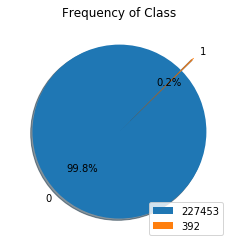

In [126]:
name_of_class, number_of_class = np.unique(data_set.iloc[:,-1], return_counts = True)
size = np.array(number_of_class, dtype = float) / np.sum(number_of_class)
explode = (number_of_class == number_of_class.min()) * 0.2

_, ax1 = plt.subplots()
ax1.set_title('Frequency of Class')
ax1.pie(size, explode = explode, labels = name_of_class, autopct = '%1.1f%%',
        shadow = True, startangle = 45)
ax1.legend(number_of_class, loc = 'lower right')

plt.show()

As we can see, the number of class in dataset is two classes, named class `0` (with frequency of 284315) and class `1` (with frequency of 492).<br>
This clearly shows that the dataset contains imbalanced class problem.

There are some possible solutions we can use,
> 1. Collect more data
> 2. Under sampling
> 3. Over sampling
> 4. Combination of under and over sampling